<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/OpenMM/OpenMM_Scripting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**NOTE**: Code must be run twice to work

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()  # Will restart the runtime; re-run after restart

!mamba install -c conda-forge ambertools -y

✨🍰✨ Everything looks OK!

Looking for: ['ambertools']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



In [ ]:
!git clone https://github.com/Iourarum/GOPY.git
%cd GOPY
!python GOPY.py generate_PG 10 10 graphene.pdb
!python GOPY.py generate_GO graphene.pdb 2 4 8 functionalized.pdb


Cloning into 'GOPY'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 197 (delta 39), reused 18 (delta 18), pack-reused 150 (from 1)
Receiving objects: 100% (197/197), 9.50 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/GOPY/GOPY
done.
GOPY.py
generate_GO
graphene.pdb
2
4
8
functionalized.pdb
Left to add:  cooh:  2 epoxy:  4 hydroxyl:  8
Left to add:  cooh:  2 epoxy:  4 hydroxyl:  7
Left to add:  cooh:  2 epoxy:  3 hydroxyl:  7
Left to add:  cooh:  2 epoxy:  3 hydroxyl:  6
Left to add:  cooh:  2 epoxy:  3 hydroxyl:  5
Left to add:  cooh:  1 epoxy:  3 hydroxyl:  5
Left to add:  cooh:  1 epoxy:  2 hydroxyl:  5
Left to add:  cooh:  0 epoxy:  2 hydroxyl:  5
Left to add:  cooh:  0 epoxy:  1 hydroxyl:  5
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  5
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  4
Left to add:  cooh:  0 epoxy:  0 hydroxyl:  3
Left to add:  cooh:  0 epox

In [ ]:
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/GGG.lib
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/C1A.lib
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/E1A.lib
!wget https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/H1A.lib
!mkdir -p FRCMOD
!wget -P FRCMOD https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/FRCMOD/GO.frcmod

--2025-01-21 06:23:37--  https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/GGG.lib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1063 (1.0K) [text/plain]
Saving to: ‘GGG.lib’

GGG.lib             100%[===================>]   1.04K  --.-KB/s    in 0s      

2025-01-21 06:23:37 (54.5 MB/s) - ‘GGG.lib’ saved [1063/1063]

--2025-01-21 06:23:37--  https://raw.githubusercontent.com/Iourarum/GOPY/master/GO_tutorial/C1A.lib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1627 (1.6K) [text/plain]
Saving to: ‘C1A.lib’

C1

In [28]:
!pip install openmm
!pip install MDAnalysis

In [33]:
from openmm.app import AmberPrmtopFile, AmberInpcrdFile, Simulation, PDBReporter, PME, HBonds
from openmm import LangevinMiddleIntegrator, Platform
from openmm.unit import kelvin, picosecond, nanometer, picoseconds
import os, numpy as np, MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
from scipy.signal import find_peaks
from scipy.spatial import cKDTree
from scipy.constants import Avogadro

def run_simulation_and_analyze(Na_count, box_dims, mass_adsorbent=1.0, initial_counts=None):
    # Create leap input for a given Na_count
    leap_content = f"""source leaprc.protein.ff14SB
source leaprc.water.tip3p
loadoff GGG.lib
loadoff C1A.lib
loadoff E1A.lib
loadoff H1A.lib
loadamberparams FRCMOD/GO.frcmod
mol = loadpdb functionalized.pdb
bondbydistance mol
solvateBox mol TIP3PBOX 5.0
addIons2 mol Na+ {Na_count}
addIons2 mol Cl- {Na_count}
saveamberparm mol mol_solv.prmtop mol_solv.inpcrd
quit
"""
    with open('leap.in', 'w') as f:
        f.write(leap_content)
    os.system('tleap -f leap.in')

    # Run simulation
    prmtop = AmberPrmtopFile('mol_solv.prmtop')
    inpcrd = AmberInpcrdFile('mol_solv.inpcrd')
    topology = prmtop.topology
    positions = inpcrd.positions

    system = prmtop.createSystem(nonbondedMethod=PME, nonbondedCutoff=1.0*nanometer, constraints=HBonds)
    integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
    platform = Platform.getPlatformByName('CPU')
    simulation = Simulation(topology, system, integrator, platform)
    simulation.context.setPositions(positions)
    simulation.minimizeEnergy()
    simulation.reporters.append(PDBReporter('trajectory.pdb', 100))
    simulation.step(5000)

    # Analyze trajectory for Ce, qe, and RDF
    u = mda.Universe('mol_solv.prmtop', 'trajectory.pdb')
    for ts in u.trajectory:
        ts.dimensions = [box_dims[0], box_dims[1], box_dims[2], 90.0, 90.0, 90.0]
    u.trajectory.rewind()

    protein = u.select_atoms('resname GGG E1A H1A C1A')
    Na = u.select_atoms('name Na+')

    # RDF computation
    r_min, r_max = 0.0, 12.0
    rdf_calc = InterRDF(protein, Na, range=(r_min, r_max), nbins=120)
    rdf_calc.run()

    peaks, _ = find_peaks(rdf_calc.rdf)
    if len(peaks) > 0:
        first_peak = peaks[0]
        inverted = -rdf_calc.rdf
        minima, _ = find_peaks(inverted, distance=10)
        cands = minima[minima > first_peak]
        r_cut = rdf_calc.bins[cands[0]] if len(cands) > 0 else r_max
    else:
        r_cut = r_max

    adsorbed = 0
    total_frames = 0
    ref_group = protein
    target_group = Na
    for ts in u.trajectory:
        p_ref = ref_group.positions
        p_tg = target_group.positions
        tr_ref = cKDTree(p_ref)
        tr_tg = cKDTree(p_tg)
        sdm = tr_ref.sparse_distance_matrix(tr_tg, max_distance=r_cut, output_type='coo_matrix')
        col_ids = np.unique(sdm.col)
        adsorbed += len(col_ids)
        total_frames += 1

    avg_adsorbed = adsorbed / total_frames if total_frames > 0 else 0.0

    MW_Na = 22.99
    if initial_counts is None:
        initial_counts = {'Na': Na_count}
    N_initial = initial_counts['Na']

    volume_A3 = box_dims[0] * box_dims[1] * box_dims[2]
    volume_L = volume_A3 * 1e-24
    N_unads = N_initial - avg_adsorbed
    C_e = (N_unads * MW_Na / Avogadro) / volume_L * 1e3  # mg/L
    q_e = (avg_adsorbed * MW_Na) / mass_adsorbent * 1e3  # mg/g

    return C_e, q_e, rdf_calc.bins, rdf_calc.rdf

/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/base.py:522: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time
/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/rdf.py:347: DeprecationWarning: The `rdf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rdf` instead
  warnings.warn(wmsg, DeprecationWarning)
/usr/local/lib/python3.11/site-packages/MDAnalysis/analysis/rdf.py:339: DeprecationWarning: The `bins` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.bins` instead
  warnings.warn(wmsg, DeprecationWarning)


Na_count: 20, Ce: 0.32 mg/L, qe: 23909.60 mg/g
Na_count: 40, Ce: 0.65 mg/L, qe: 38163.40 mg/g
Na_count: 60, Ce: 0.98 mg/L, qe: 45980.00 mg/g
Na_count: 80, Ce: 1.31 mg/L, qe: 61153.40 mg/g


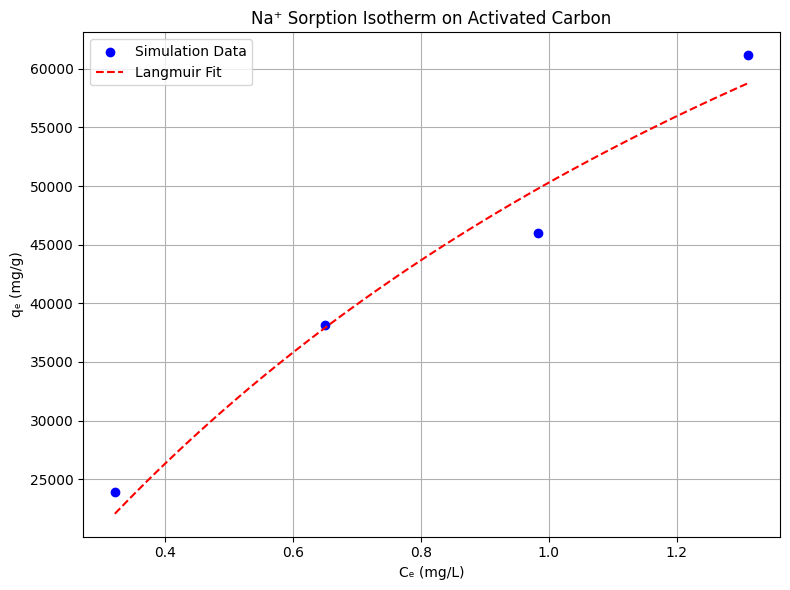

Langmuir fit parameters:
q_max = 128103.12 mg/g
K_L = 0.6462 L/mg


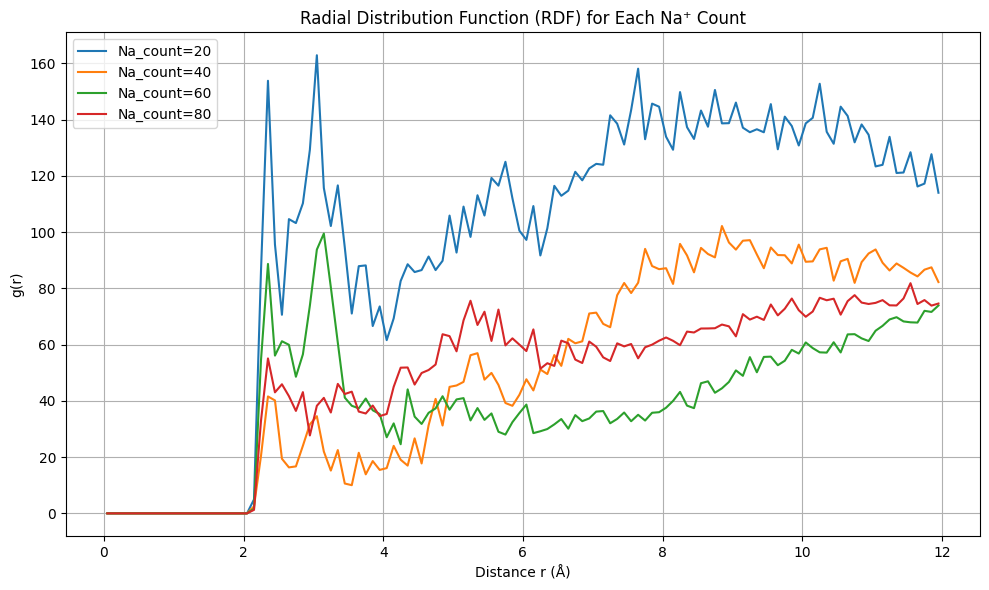

In [35]:
# Loop over different Na⁺ counts
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

Na_counts = [20, 40, 60, 80]
box_dims = (150.0, 150.0, 100.0)
Ce_values = []
qe_values = []
rdf_data = []

for count in Na_counts:
    Ce, qe, r, rdf = run_simulation_and_analyze(count, box_dims, mass_adsorbent=1.0, initial_counts={'Na': count})
    Ce_values.append(Ce)
    qe_values.append(qe)
    rdf_data.append((count, r, rdf))
    print(f"Na_count: {count}, Ce: {Ce:.2f} mg/L, qe: {qe:.2f} mg/g")

# Save simulation data to CSV
with open('sorption_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Na_count', 'Ce (mg/L)', 'q_e (mg/g)'])
    for count, Ce, qe in zip(Na_counts, Ce_values, qe_values):
        writer.writerow([count, Ce, qe])

# Langmuir isotherm fitting and plotting
def langmuir(C, q_max, K_L):
    return (q_max * K_L * C) / (1 + K_L * C)

if len(Ce_values) > 2:
    params, _ = curve_fit(langmuir, Ce_values, qe_values, p0=[max(qe_values), 0.1], maxfev = 10000)
    q_max, K_L = params

    Ce_fit = np.linspace(min(Ce_values), max(Ce_values), 100)
    qe_fit = langmuir(Ce_fit, *params)

    plt.figure(figsize=(8, 6))
    plt.scatter(Ce_values, qe_values, c='b', label='Simulation Data')
    plt.plot(Ce_fit, qe_fit, 'r--', label='Langmuir Fit')
    plt.xlabel('Cₑ (mg/L)')
    plt.ylabel('qₑ (mg/g)')
    plt.title('Na⁺ Sorption Isotherm on Activated Carbon')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Langmuir fit parameters:\nq_max = {q_max:.2f} mg/g\nK_L = {K_L:.4f} L/mg")

# RDF plotting for each trial
plt.figure(figsize=(10, 6))
for count, r, rdf in rdf_data:
    plt.plot(r, rdf, label=f'Na_count={count}')
plt.xlabel('Distance r (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function (RDF) for Each Na⁺ Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()